# Eager Execution and Keras

The architecture of TensorFlow is designed to make it easy to fit machine learning models across a variety of architectures, automatically optimizing how computations are allocated to the available resources. 

![](images/tf_architecture.png)

The TensorFlow user is responsible for specifying their model in the Python client layer. When this is done well, it results in a very performant model. However, as we have seen constructing a static model is not particularly intuitive (and certainly not *Pythonic*). In order to help alleviate this, some changes to the API have been implemented in newer versions of TensorFlow. Most important among them are:

1. Eager execution model
2. Integration of the Keras library

We will introduce both of these here.

## Eager Execution

TensorFlow's eager execution is an imperative programming environment that
evaluates operations immediately, without building graphs. Operations return
concrete values instead of constructing a computational graph to run later. This better aligns users’ expectations about the programming model better with TensorFlow, making it easier to learn and apply.

Eager execution is a flexible machine learning platform for research and
experimentation, providing:

* *An intuitive interface*—Structure your code naturally and use Python data
  structures. Quickly iterate on small models and small data.
* *Easier debugging*—Call ops directly to inspect running models and test
  changes. Use standard Python debugging tools for immediate error reporting.
* *Natural control flow*—Use Python control flow instead of graph control
  flow, simplifying the specification of dynamic models.

The tradeoff inherent in eager execution is that models run with increased overhead, typically resulting in slower performance (though this is continually being improved).

In an interactive computing environment like Jupyter, eager execution must be specified before TensorFlow is used.  This is done by calling `tf.enable_eager_execution()` near the top of the notebook.

In [1]:
import tensorflow as tf

tf.enable_eager_execution()

Enabling eager execution changes how TensorFlow operations behave—now they
immediately evaluate and return their values to Python. `tf.Tensor` objects
reference concrete values instead of symbolic handles to nodes in a computational
graph. Since there isn't a computational graph to build and run later in a
session, it's easy to inspect results using `print()` or a debugger. Evaluating,
printing, and checking tensor values does not break the flow for computing
gradients.

In [2]:
import numpy as np
np.random.seed(42)

x = np.random.random((2,2))
m = tf.matmul(x, x)

print("matrix multiplication result:, {}".format(m))

matrix multiplication result:, [[0.83619741 0.92523383]
 [0.71237548 1.05430909]]


In [3]:
a = tf.constant([[1, 2],
                 [3, 4]])

# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [4]:
# Operator overloading is supported
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


Eager execution works nicely with [NumPy](http://www.numpy.org/). NumPy
operations accept `tf.Tensor` arguments. TensorFlow
[math operations](https://www.tensorflow.org/api_guides/python/math_ops) convert
Python objects and NumPy arrays to `tf.Tensor` objects. The
`tf.Tensor.numpy` method returns the object's value as a NumPy `ndarray`.

In [5]:
a.numpy()

array([[1, 2],
       [3, 4]], dtype=int32)

The `tf.contrib.eager` module contains symbols available to both eager and graph execution
environments and is useful for writing code to [work with graphs](#work_with_graphs):

In [6]:
tfe = tf.contrib.eager

## Dynamic control flow

A major benefit of eager execution is that all the functionality of the host
language is available while your model is executing. For example, we can use Python's control flow statements like `for` loops or conditionals:

In [7]:
def fibonacci(n):
    n = tf.convert_to_tensor(n)
    if n < 2:
        return n
    a, b = tf.constant(0), tf.constant(1)
    for i in range(n.numpy()+1):
        a, b = b, a + b
    return b

In [8]:
print(fibonacci(2))

tf.Tensor(3, shape=(), dtype=int32)


## Eager training

### Computing gradients

[Automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)
is useful for implementing machine learning algorithms such as
[backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training
neural networks. During eager execution, use `tf.GradientTape` to trace
operations for computing gradients later.

`tf.GradientTape` is an opt-in feature to provide maximal performance when
not tracing. Since different operations can occur during each call, all
forward-pass operations get recorded to a "tape". To compute the gradient, play
the tape backwards and then discard. A particular `tf.GradientTape` can only
compute one gradient; subsequent calls throw a runtime error.

In [9]:
w = tf.Variable([[1.0]])

with tf.GradientTape() as tape:
    loss = w * w

tape.gradient(loss, w)

<tf.Tensor: id=40, shape=(1, 1), dtype=float32, numpy=array([[2.]], dtype=float32)>

# Fitting Neural Networks with Keras

In much the same way that PyMC3 allows Bayesian models to be specified in Theano at a high level, Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow. Keras is a modular, extensible library that allows for easy construction of deep learning models. It includes classes for building either convolutional networks and recurrent networks, and supports CPU and GPU computation.

Keras is used for fast prototyping, advanced research, and production, with three key advantages:

1. **User friendly**: Keras has a simple, consistent interface optimized for common use cases. It provides clear and actionable feedback for user errors.
2. **Modular and composable**: Keras models are made by connecting configurable building blocks together, with few restrictions.
3. **Easy to extend**: Write custom building blocks to express new ideas for research. Create new layers, loss functions, and develop state-of-the-art models.

Keras was recently integrated into the TensorFlow project, so it does not have to be separately downloaded, but is available as a sub-module.

In [62]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

To learn how deep neural networks are constructed in Keras, we will use a famous benchmarking dataset, MNIST. The MNIST database of handwritten digits, which includes a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST.

The original black and white images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. This results in a vector of 784 values for each image.

In [12]:
from tensorflow.keras.datasets import mnist

# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = mnist.load_data()

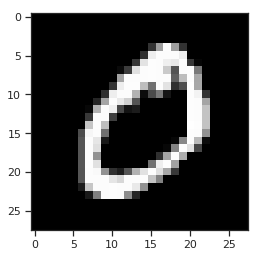

In [13]:
plt.imshow(mnist_images[1].reshape(28,28), cmap='gray');

We can convert the raw data for use in Keras.

---

### The Dataset API

A more elegant way to feed data into your model (compared to feeding NumPy arrays into a session) is to set up an **input pipeline**, using the TensorFlow Dataset API. A Dataset can be used to represent an input pipeline as a nested structures of tensors and an associated set of transformations that act on those tensors.

This is what it looks like. Consider some arbitrary input data, in the form of a NumPy array:

In [14]:
fake_data = np.random.normal((100, 5))

The `from_tensor_slices` function creates a `Dataset` whose elements are slices of the given tensors:

In [15]:
a_dataset = tf.data.Dataset.from_tensor_slices(fake_data)

The `make_one_shot_iterator` creates an `Iterator` for enumerating the elements of this dataset. As we will see, this facilitates mini-batch processing.

In [16]:
data = a_dataset.make_one_shot_iterator().get_next()
data

<tf.Tensor: id=45, shape=(), dtype=float64, numpy=99.76584662527667>

---

In the case of our MNIST image data, we first flatten the image data, convert it to floats, and scale before feeding it into a `Dataset`.

In [17]:
dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images.reshape(mnist_images.shape[0], 784)/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))

Finally, the dataset is shuffled and configured to batch-update.

In [18]:
dataset = dataset.shuffle(1000).batch(32)

### Building the model

The simplest model class in Keras is the `Sequential` class object. It allows networks to be constructed layer by layer, beginning with the data input and terminating with an output layer. Only the input layer requires explicit dimensions to be passed (via the keyword argument `input_dim`); the rest are inferred based on the size of the layer. 

Between layers, we also define an **activation** function for the outputs from the previous layer.

Here is a simple network with two hidden layers. The output layer will be of size 10, corresponding the the number of classes in the dataset.

In [19]:
mnist_model = Sequential()
mnist_model.add(Dense(512, input_shape=(784,)))
mnist_model.add(Activation('relu'))
mnist_model.add(Dense(512))
mnist_model.add(Activation('relu'))
mnist_model.add(Dense(10))
mnist_model.add(Activation('softmax'))

mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Train a model

The following example creates a multi-layer model that classifies the standard
MNIST handwritten digits. It demonstrates the optimizer and layer APIs to build
trainable graphs in an eager execution environment.

Activations can either be used through an `Activation` layer, as we have done here, or through the `activation` argument supported by all forward layers:

```python
model.add(Dense(64))
model.add(Activation('tanh'))
```

This is equivalent to:

```python
model.add(Dense(64, activation='tanh'))
```

Thus, a more concise way of specifying the same model is:

In [20]:
mnist_model = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


For the hidden layers, we have used a **rectified linear unit (RELU)**. This is the simple function:

$$f(x) = \max(0, x)$$

This activation has beens shown to perform well in the training of deep neural networks for supervised learning. It is a sparse activation, and has efficient gradient propagation.

We use the **softmax** activation for the output layer because, like the logistic, it transforms inputs to the unit interval. 

### Configure the layers

There are many tf.keras.layers available with some common constructor parameters:

- `activation`: Set the activation function for the layer. This parameter is specified by the name of a built-in function or as a callable object. By default, no activation is applied.
- `kernel_initializer` and `bias_initializer`: The initialization schemes that create the layer's weights (kernel and bias). This parameter is a name or a callable object. This defaults to the "Glorot uniform" initializer.
- `kernel_regularizer` and `bias_regularizer`: The regularization schemes that apply the layer's weights (kernel and bias), such as L1 or L2 regularization. By default, no regularization is applied.

The following instantiates `tf.keras.layers.Dense` layers using constructor arguments:

In [21]:
from tensorflow.keras import regularizers, initializers

# Create a sigmoid layer:
Dense(64, activation='sigmoid')
# Or:
Dense(64, activation=tf.sigmoid)

# A linear layer with L1 regularization of factor 0.01 applied to the kernel matrix:
Dense(64, kernel_regularizer=regularizers.l1(0.01))
# A linear layer with L2 regularization of factor 0.01 applied to the bias vector:
Dense(64, bias_regularizer=regularizers.l2(0.01))

# A linear layer with a kernel initialized to a random orthogonal matrix:
Dense(64, kernel_initializer='orthogonal')
# A linear layer with a bias vector initialized to 2.0s:
Dense(64, bias_initializer=initializers.constant(2.0))

### Fitting the model

Fitting the model first requires a compilation step, for which we specify three arguments:

- an `optimizer`. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the `Optimizer` class. See: [optimizers](https://keras.io/optimizers/).
- a `loss` function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function (such as `categorical_crossentropy` or `mse`), or it can be an objective function. See: [loss functions](https://keras.io/losses/).
- a list of `metrics`. For any classification problem you will want to set this to `metrics=['accuracy']`. A metric could be the string identifier of an existing metric (only `accuracy` is supported at this point), or a custom metric function. See: [metrics](https://keras.io/metrics/).

Here, we will use the `sparse_softmax_cross_entropy` loss function, which computes sparse softmax cross entropy between logits and labels by measuring the probability error in discrete classification tasks in which the classes are mutually exclusive.


Even without training, call the model and inspect the output in eager execution:

In [22]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[0.17786692 0.11224262 0.13480453 0.08004694 0.06253795 0.04824175
  0.09407314 0.08771106 0.08631367 0.11616141]]


While keras models have a builtin training loop (using the `fit` method), sometimes you need more customization. Here's an example, of a training loop implemented with eager:

In [23]:
optimizer = tf.train.AdamOptimizer()

loss_history = []

In [24]:
for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 80 == 0:
        print()
    print('.', end='')
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

    loss_history.append(loss_value.numpy())
    grads = tape.gradient(loss_value, mnist_model.variables)
    optimizer.apply_gradients(zip(grads, mnist_model.variables),
                            global_step=tf.train.get_or_create_global_step())


................................................................................
................................................................................
................................................................................
................................................................................
................................................................................

Text(0, 0.5, 'Loss [entropy]')

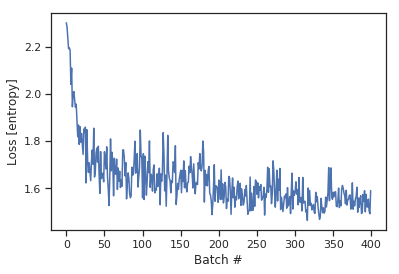

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

## Build a model

Many machine learning models are represented by composing layers. When
using TensorFlow with eager execution you can either write your own layers or
use a layer provided in the `tf.keras.layers` package.

As we have seen, when composing layers into models you can use `tf.keras.Sequential` to represent
models which are a linear stack of layers. It is easy to use for basic models:

In [26]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(784,)),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

Alternatively, organize models in classes by inheriting from `tf.keras.Model`.
This is a container for layers that is a layer itself, allowing `tf.keras.Model`
objects to contain other `tf.keras.Model` objects.

In [56]:
class MNISTModel(tf.keras.Model):
    
    def __init__(self):
        super(MNISTModel, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(units=512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=512, activation='relu')
        self.dense_out = tf.keras.layers.Dense(units=10, activation='softmax')

    def call(self, input):
        """Run the model."""
        
        result = self.dense1(input)
        result = self.dense2(result)
        result = self.dense_out(result)
        
        return result

model = MNISTModel()

It's not required to set an input shape for the `tf.keras.Model` class since
the parameters are set the first time input is passed to the layer.

`tf.keras.layers` classes create and contain their own model variables that
are tied to the lifetime of their layer objects. To share layer variables, share
their objects.

In [59]:
optimizer = tf.train.AdamOptimizer()

loss_history = []

for (batch, (images, labels)) in enumerate(dataset.take(400)):
    if batch % 80 == 0:
        print()
    print('.', end='')
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

    loss_history.append(loss_value.numpy())
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())


................................................................................
................................................................................
................................................................................
................................................................................
................................................................................

Since `tf.gradients` does not work under eager execution, the `tf.GradientTape` class, which records operations within in its context manager, and constructs a computation graph from them. They are then applied with `apply_gradients` for backpropagation.

Text(0, 0.5, 'Loss [entropy]')

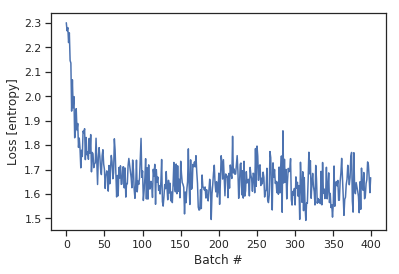

In [60]:
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

## Example: Iris classification problem

Recall the iris morphometric dataset, which includes measurements from three species:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Let's create a custom neural network classifier using Keras in eager execution mode.

## Import and parse the training dataset

Download the dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [63]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /home/fonnesbeck/.keras/datasets/iris_training.csv


In [64]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [65]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a `Dataset`

Since the dataset is a CSV-formatted text file, we can use the `make_csv_dataset` function to parse the data into a `Dataset`. Since this function generates data for training models, the default behavior is to shuffle the data (`shuffle=True, shuffle_buffer_size=10000`), and repeat the dataset forever (`num_epochs=None`). We can also set the `batch_size` parameter.

In [67]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

The `make_csv_dataset` function returns a `tf.data.Dataset` of `(features, label)` pairs, where `features` is a dictionary: `{'feature_name': value}`

With eager execution enabled, these `Dataset` objects are iterable. Let's look at a batch of features:

In [68]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=456550, shape=(32,), dtype=float32, numpy=
              array([5.2, 4.8, 4.7, 5.8, 7.2, 7.4, 6.6, 6.4, 6.2, 6. , 5.3, 5.8, 6.1,
                     6.5, 5.6, 5.8, 7.7, 6.1, 5.4, 6.9, 5.1, 5.2, 5. , 6.8, 6. , 5.5,
                     5.6, 4.6, 7.7, 4.4, 5.8, 6.7], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=456551, shape=(32,), dtype=float32, numpy=
              array([2.7, 3.1, 3.2, 2.7, 3.2, 2.8, 2.9, 2.7, 2.2, 2.7, 3.7, 2.6, 2.8,
                     2.8, 2.7, 2.7, 3.8, 2.6, 3.9, 3.2, 3.8, 3.5, 3.5, 2.8, 2.2, 2.6,
                     2.5, 3.1, 2.6, 3. , 4. , 3. ], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=456548, shape=(32,), dtype=float32, numpy=
              array([3.9, 1.6, 1.3, 5.1, 6. , 6.1, 4.6, 5.3, 4.5, 5.1, 1.5, 4. , 4.7,
                     4.6, 4.2, 4.1, 6.7, 5.6, 1.7, 5.7, 1.6, 1.5, 1.3, 4.8, 5. , 4.4,
                     3.9, 1.5, 6.9, 1.3

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`.

This function uses the `tf.stack` function which takes values from a list of tensors and creates a combined tensor at the specified dimension.

In [70]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

Then use the `Dataset.map` method to pack the `features` of each `(features,label)` pair into the training dataset:

In [71]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the `Dataset` are now arrays with shape `(batch_size, num_features)`. Let's look at the first few examples:

In [72]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[7.7 3.8 6.7 2.2]
 [6.4 3.2 5.3 2.3]
 [7.6 3.  6.6 2.1]
 [5.6 2.9 3.6 1.3]
 [5.5 2.4 3.7 1. ]], shape=(5, 4), dtype=float32)


### Create a model using Keras

We will construct a simple network of two `Dense` layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required.

In [73]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

### Using the model

Let's have a quick look at what this model does to a batch of features:

In [74]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=456706, shape=(5, 3), dtype=float32, numpy=
array([[ 3.100594  , -3.8644023 , -0.94735646],
       [ 2.651278  , -3.2549272 , -0.77409494],
       [ 2.8142893 , -3.6942174 , -1.0679533 ],
       [ 2.245101  , -2.518532  , -0.5635382 ],
       [ 2.0281365 , -2.3910842 , -0.6384946 ]], dtype=float32)>

Here, each example returns a logit for each class. 

The `softmax` function transforms these logits to a probability for each class.

In [75]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=456712, shape=(5, 3), dtype=float32, numpy=
array([[9.8193008e-01, 9.2730176e-04, 1.7142648e-02],
       [9.6594131e-01, 2.6297739e-03, 3.1428967e-02],
       [9.7838235e-01, 1.4584785e-03, 2.0159142e-02],
       [9.3560988e-01, 7.9850079e-03, 5.6405097e-02],
       [9.2461646e-01, 1.1135721e-02, 6.4247824e-02]], dtype=float32)>

Taking the `tf.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [76]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [2 2 2 1 1 1 0 2 2 0 2 2 2 2 1 2 0 2 0 1 0 1 0 2 0 0 0 2 0 0 1 2]


### Define the loss and gradient function

We will use the `categorical_crossentropy` loss function, which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [77]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 2.7228729724884033


Since we are operating in eager mode, we will create a `GradientTape` context to apply the loss function:

In [78]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

We will use the `GradientDescentOptimizer` that implements the *stochastic gradient descent* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill.

Let's setup the optimizer and the `global_step` counter:

In [79]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

We'll use this to calculate a single optimization step:

In [80]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 4000, Initial Loss: 2.7228729724884033
Step: 4001,         Loss: 1.8171124458312988


### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. Choosing the right number usually requires both experience and experimentation.

In [81]:
# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.386, Accuracy: 62.500%
Epoch 050: Loss: 0.430, Accuracy: 74.167%
Epoch 100: Loss: 0.310, Accuracy: 90.833%
Epoch 150: Loss: 0.242, Accuracy: 97.500%
Epoch 200: Loss: 0.164, Accuracy: 97.500%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. We want to ensure that the *loss* go down and the *accuracy* go up.

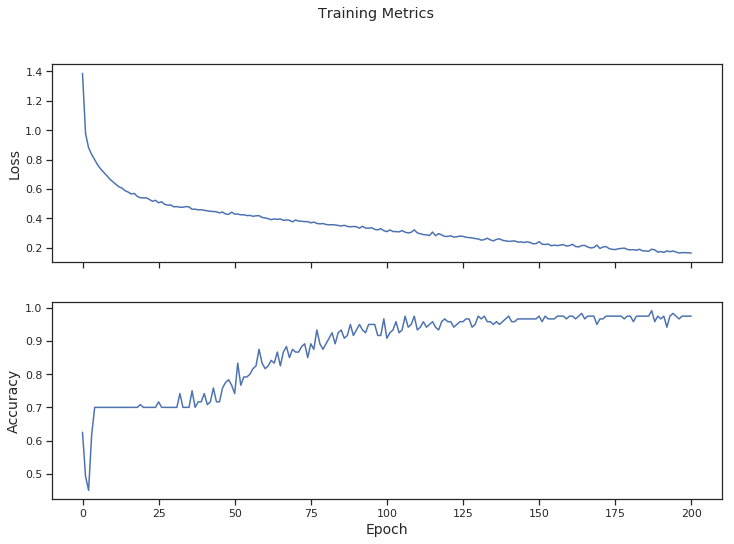

In [82]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);

### Model testing

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the CSV text file and parse that values, then give it a little shuffle:

In [83]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [84]:
test_dataset = tf.contrib.data.make_csv_dataset(
    test_fp,
    batch_size, 
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single epoch of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label.

In [85]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


We can see on the last batch, for example, the model is usually correct:

In [86]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=579314, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## Exercise

Build a multi-layer neural network to predict wine varietals using the wine chemistry dataset.

In [ ]:
wine = pd.read_table("../data/wine.dat", sep='\s+')

attributes = ['Alcohol',
            'Malic acid',
            'Ash',
            'Alcalinity of ash',
            'Magnesium',
            'Total phenols',
            'Flavanoids',
            'Nonflavanoid phenols',
            'Proanthocyanins',
            'Color intensity',
            'Hue',
            'OD280/OD315 of diluted wines',
            'Proline']

grape = wine.pop('region')
y = grape.values
wine.columns = attributes
X = wine[['Alcohol', 'Proline']].values

In [ ]:
# Write your answer here

---

## References

- [TensorFlow eager execution](https://www.tensorflow.org/guide/eager)
- [TensorFlow datasets](https://www.tensorflow.org/guide/datasets)
- [TensorFlow guide to Keras](https://www.tensorflow.org/guide/keras)